### www.cmiw.cn 和 bbs.cmiw.cn 是爬虫web_crawler.ipynb爬下来的网页，本实验主要使用www.cmiw.cn 的数据

In [7]:
!dir

 驱动器 C 中的卷没有标签。
 卷的序列号是 D4A3-95FD

 C:\Users\Mark\1AI.NPL\AI.NLP\lecture7 的目录

2019-01-04  19:06    <DIR>          .
2019-01-04  19:06    <DIR>          ..
2019-01-04  16:34    <DIR>          .ipynb_checkpoints
2019-01-04  19:06    <DIR>          bbs.cmiw.cn
2019-01-04  17:21    <DIR>          log
2019-01-04  17:44            38,756 simple_search_engine.ipynb
2019-01-04  19:06            10,991 web_crawler.ipynb
2019-01-04  19:07    <DIR>          www.cmiw.cn
2019-01-04  19:05    <DIR>          www.cmiw.cn_archive
               2 个文件         49,747 字节
               7 个目录 15,440,273,408 可用字节


In [16]:
import os

file_base = "www.cmiw.cn_archive"
text_base = "www.cmiw.cn_text"

In [6]:
import html2text

html_handler = html2text.HTML2Text()

html_handler.ignore_links = True

In [19]:
from tqdm import tqdm

for f in tqdm(os.listdir(file_base)):
    open(os.path.join(text_base, f),'w',encoding='utf-8').write(html_handler.handle(open(os.path.join(file_base, f)).read()))

100%|██████████████████████████████████████████████████████████████████████████████| 5592/5592 [03:50<00:00, 24.27it/s]


In [20]:
import os

len(os.listdir(text_base))

5592

### 把所有的内容作为语料库，先分词

In [21]:
import jieba

def cut(string): return ' '.join(jieba.cut(string))

In [25]:
corpus = []

for f in tqdm(os.listdir(text_base)):
    corpus.append(cut(open(os.path.join(text_base, f),encoding = 'utf-8').read()))

  0%|                                                                                         | 0/5592 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Mark\AppData\Local\Temp\jieba.cache
Loading model cost 0.968 seconds.
Prefix dict has been built succesfully.
100%|██████████████████████████████████████████████████████████████████████████████| 5592/5592 [01:11<00:00, 78.40it/s]


### TF-IDF向量化，TF-IDF参考lecture6/TF_DF_wordcloud_relatedwords.ipynb

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

tf_idf_vec = vectorizer.fit_transform(corpus)

NameError: name 'tfidf' is not defined

In [27]:
transposed_tfidf_vec = tf_idf_vec.transpose()

In [28]:
import numpy as np

transposed_tfidf_array = transposed_tfidf_vec.toarray()
transposed_tfidf_array.shape

(84284, 5592)

In [29]:
np.where(transposed_tfidf_array[10])

(array([223, 227], dtype=int64),)

In [38]:
def get_word_id(word):
    return vectorizer.vocabulary_.get(word, None)

def get_candidates_ids(input_string):
    return [get_word_id(c) for c in cut(input_string).split()]

def get_candidates_pat(input_string):
    return '({})'.format('|'.join(cut(input_string).split()))

In [39]:
get_word_id('深圳')

62650

In [44]:
from functools import reduce
from operator import and_
import re
from scipy.spatial.distance import cosine

def search_engine(query):
    candidates_ids = get_candidates_ids(query)
    
    v1 = vectorizer.transform([cut(query)]).toarray()[0]
    
    candidates = [set(np.where(transposed_tfidf_array[_id])[0]) for _id in candidates_ids]
    
    merged_candidates = reduce(and_, candidates)
    
    pat = re.compile(get_candidates_pat(query))
    
    vector_with_id = [(tf_idf_vec[i], i) for i in merged_candidates]
    
    sorted_vector_with_ids = sorted(vector_with_id, key=lambda x: cosine(x[0].toarray(), v1))

    sorted_ids = [i for v, i in sorted_vector_with_ids]
    
    for c in merged_candidates:
        output = pat.sub(repl='** \g<1> ** ', string=corpus[c])
        yield ''.join(output.split())

In [48]:
with open('search_result.md', 'w',encoding = 'utf-8') as f:
    for i, document in enumerate(search_engine('机械工程')):
        f.write('## search result {}\n'.format(i))
        f.write(document+'\n')
    print('done!')

done!


## Page Rank
### Refference https://blog.csdn.net/hguisu/article/details/7996185

In [1]:
import networkx as nx
import random
from string import ascii_letters

def generate_name(): return ''.join([random.choice(ascii_letters.upper()) for _ in range(3)])

In [2]:
social_graph = {
    "Yao": ['Guo', 'Wang', 'Tian', 'Tim'] + [generate_name() for _ in range(4)], 
    "Guo": ['Li'] + [generate_name() for _ in range(5)],
    "Wang": ["Li_2"] + [generate_name() for _ in range(5)], 
    "Li_2": [generate_name() for _ in range(5)], 
    "Li": [generate_name() for _ in range(1)],
}

In [3]:
social_network = nx.graph.Graph(social_graph)

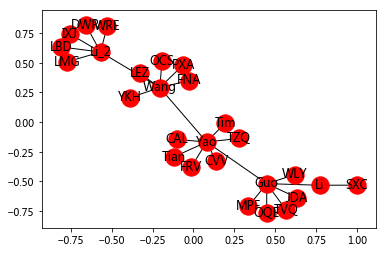

In [4]:
%matplotlib inline

nx.draw_networkx(social_network)

In [5]:
sorted(nx.pagerank(social_network).items(), key=lambda x: x[1], reverse=True)

[('Yao', 0.14018616244938112),
 ('Guo', 0.12625952492883674),
 ('Wang', 0.12354105488402628),
 ('Li_2', 0.11100157862592008),
 ('Li', 0.04009295437632798),
 ('SXC', 0.022595018111845305),
 ('LBD', 0.021279981196290158),
 ('LMG', 0.021279981196290158),
 ('DWR', 0.021279981196290158),
 ('IXJ', 0.021279981196290158),
 ('WRE', 0.021279981196290158),
 ('WLY', 0.02088716348418851),
 ('OQE', 0.02088716348418851),
 ('MPF', 0.02088716348418851),
 ('TVQ', 0.02088716348418851),
 ('JDA', 0.02088716348418851),
 ('YKH', 0.020557581368083087),
 ('OCS', 0.020557581368083087),
 ('LEZ', 0.020557581368083087),
 ('PXA', 0.020557581368083087),
 ('FNA', 0.020557581368083087),
 ('Tian', 0.020450012730142263),
 ('Tim', 0.020450012730142263),
 ('CVV', 0.020450012730142263),
 ('CAL', 0.020450012730142263),
 ('TZQ', 0.020450012730142263),
 ('FRV', 0.020450012730142263)]